In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown as md, Latex, Math

import statsmodels.api as sm
from patsy import dmatrices
import yfinance as yf
from datetime import datetime

import wrds
connection = wrds.Connection()

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
plt.style.use("bmh")

Loading library list...
Done


# Helper Functions

In [2]:
def convert_to_date(date):
    return pd.to_datetime(date[:4]+"/"+date[4:6]+"/"+date[6:]).date()

convert_to_date("19721231")

def get_rnd(xrd_list: pd.Series)->pd.Series:
    '''Function to calculate R&D investment over the last 5 years'''
    return xrd_list.rolling(window=5).apply(lambda x: (np.array([0.2, 0.4, 0.6, 0.8, 0.1]) @ np.array(x)))
# get_rnd(yearly_xrd.iloc[-1]).tail(10)

def assign_quantile(xrd_list: pd.Series)->pd.Series:
    '''Function to assign each LPERMNO to a quantile depending on its R&D Investment'''
    try:
        arr = pd.qcut(xrd_list, q = 6, labels= ["Low",2,3,4,"High"], duplicates= "drop")
        arr = arr.cat.add_categories('Non R&D')
        arr.loc[pd.isna(arr)] = "Non R&D"
    except:
        arr = pd.qcut(xrd_list, q = 5, labels= ["Low",2,3,4,"High"], duplicates= "drop")
        arr = arr.cat.add_categories('Non R&D')
        arr.loc[pd.isna(arr)] = "Non R&D"
    return arr

# assign_quantile(yearly_rcd[1989.0]).value_counts()

# Read CCM Fundamentals Annual

In [3]:
ccm_fundamentals_annual = pd.read_csv("df_fa.csv")

# USD Only
ccm_fundamentals_annual = ccm_fundamentals_annual[ccm_fundamentals_annual["curcd"] == "USD"]
ccm_fundamentals_annual["fyear"] = ccm_fundamentals_annual["datadate"].progress_apply(lambda x: convert_to_date(str(x)).year)
ccm_fundamentals_annual["me"] = ccm_fundamentals_annual[["csho", "prcc_c"]].apply(lambda r: (r["csho"]*r["prcc_c"]), axis = 1)

# Positive ME only:
ccm_fundamentals_annual[ccm_fundamentals_annual["me"] > 0]
ccm_fundamentals_annual

  0%|          | 0/271587 [00:00<?, ?it/s]

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,curcd,csho,xrd,exchg,costat,sich,prcc_c,prcc_f,sic,me
0,1000,25881,19761231,1976,INDL,C,D,STD,AE.2,000032102,USD,2.207,NaN,12,I,NaN,5.7500,5.7500,3089.0,12.690250
1,1000,25881,19771231,1977,INDL,C,D,STD,AE.2,000032102,USD,2.226,NaN,12,I,NaN,9.2500,9.2500,3089.0,20.590500
2,1001,10015,19831231,1983,INDL,C,D,STD,AMFD.,000165100,USD,3.568,0.000,14,I,NaN,7.2500,7.2500,5812.0,25.868000
3,1001,10015,19841231,1984,INDL,C,D,STD,AMFD.,000165100,USD,3.568,NaN,14,I,NaN,3.7500,3.7500,5812.0,13.380000
4,1001,10015,19851231,1985,INDL,C,D,STD,AMFD.,000165100,USD,3.988,0.000,14,I,NaN,10.1250,10.1250,5812.0,40.378500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276002,332115,80577,20201231,2020,INDL,C,D,STD,ARMP,04216R102,USD,18.688,14.444,12,A,2836.0,2.9849,2.9849,2836.0,55.781811
276003,335466,14756,20191231,2019,INDL,C,D,STD,HOFSQ,G4511M108,USD,25.662,NaN,19,A,4400.0,1.0173,1.0173,NaN,26.105953
276004,339965,19654,20210131,2021,INDL,C,D,STD,SNOW,833445109,USD,287.918,237.946,11,A,7370.0,281.4000,272.4500,7370.0,81020.125200
276005,345920,20194,20201231,2020,INDL,C,D,STD,HYFM,44888K209,USD,33.500,NaN,14,A,3524.0,52.5800,52.5800,3524.0,1761.430000


In [4]:
# SIC Codes
ccm_fundamentals_annual["sic"] = ccm_fundamentals_annual[["sic","sich"]].apply(lambda row: (row["sich"] if np.isnan(row["sic"]) else row["sic"]), axis =1)
ccm_fundamentals_annual = ccm_fundamentals_annual.drop("sich", axis = 1)
ccm_fundamentals_annual

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,curcd,csho,xrd,exchg,costat,prcc_c,prcc_f,sic,me
0,1000,25881,19761231,1976,INDL,C,D,STD,AE.2,000032102,USD,2.207,NaN,12,I,5.7500,5.7500,3089.0,12.690250
1,1000,25881,19771231,1977,INDL,C,D,STD,AE.2,000032102,USD,2.226,NaN,12,I,9.2500,9.2500,3089.0,20.590500
2,1001,10015,19831231,1983,INDL,C,D,STD,AMFD.,000165100,USD,3.568,0.000,14,I,7.2500,7.2500,5812.0,25.868000
3,1001,10015,19841231,1984,INDL,C,D,STD,AMFD.,000165100,USD,3.568,NaN,14,I,3.7500,3.7500,5812.0,13.380000
4,1001,10015,19851231,1985,INDL,C,D,STD,AMFD.,000165100,USD,3.988,0.000,14,I,10.1250,10.1250,5812.0,40.378500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276002,332115,80577,20201231,2020,INDL,C,D,STD,ARMP,04216R102,USD,18.688,14.444,12,A,2.9849,2.9849,2836.0,55.781811
276003,335466,14756,20191231,2019,INDL,C,D,STD,HOFSQ,G4511M108,USD,25.662,NaN,19,A,1.0173,1.0173,4400.0,26.105953
276004,339965,19654,20210131,2021,INDL,C,D,STD,SNOW,833445109,USD,287.918,237.946,11,A,281.4000,272.4500,7370.0,81020.125200
276005,345920,20194,20201231,2020,INDL,C,D,STD,HYFM,44888K209,USD,33.500,NaN,14,A,52.5800,52.5800,3524.0,1761.430000


In [5]:
yearly_xrd = ccm_fundamentals_annual.groupby(["LPERMNO","fyear"])["xrd","me"].mean().unstack()
yearly_xrd

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_56461/1478010223.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  yearly_xrd = ccm_fundamentals_annual.groupby(["LPERMNO","fyear"])["xrd","me"].mean().unstack()


xrd                                               ...          me  \
fyear   1976 1977 1978 1979 1980 1981 1982 1983 1984 1985  ...        2012   
LPERMNO                                                    ...               
10000    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10001    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    78.09210   
10002    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10003    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10005    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...         ...   
93432    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
93433    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    19.16053   
93434    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    53.05956   
93435    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
93436    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  3868.42818   

                                                                           \
fyear            2013         2014         2015         2016         2017   
LPERMNO                                                                     
10000             NaN          NaN          NaN          NaN          NaN   
10001       83.929560    115.57776     78.26225    132.02600          NaN   
10002             NaN          NaN          NaN          NaN          NaN   
10003             NaN          NaN          NaN          NaN          NaN   
10005             NaN          NaN          NaN          NaN          NaN   
...               ...          ...          ...          ...          ...   
93432             NaN          NaN          NaN          NaN          NaN   
93433       16.114140      3.14358     44.97500     20.05885      8.18545   
93434       80.508800     46.56000     56.77588     78.48060     70.12200   
93435             NaN          NaN          NaN          NaN          NaN   
93436    18516.456039  27954.26808  31543.31425  34523.97009  52554.94595   

                                                      
fyear            2018        2019          2020 2021  
LPERMNO                                               
10000             NaN         NaN           NaN  NaN  
10001             NaN         NaN           NaN  NaN  
10002             NaN         NaN           NaN  NaN  
10003             NaN         NaN           NaN  NaN  
10005             NaN         NaN           NaN  NaN  
...               ...         ...           ...  ...  
93432             NaN         NaN           NaN  NaN  
93433        4.961642         NaN           NaN  NaN  
93434       44.060830     69.8838      97.95869  NaN  
93435             NaN         NaN           NaN  NaN  
93436    57442.278400  75717.7300  677443.20000  NaN  

[25464 rows x 92 columns]

Calculate $ RCD_t = f(XRD_t, XRD_{t-1}, XRD_{t-2}, XRD_{t-3}, XRD_{t-4}, XRD_{t-5}) / ME_t $

In [6]:
yearly_rcd = yearly_xrd["xrd"].apply(lambda row: (get_rnd(row)), axis = 1)
yearly_rcd = yearly_rcd/yearly_xrd["me"]
yearly_rcd

fyear,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
LPERMNO,,,,,,,,,,,,,,,,,,,,,
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.764937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.018439,0.023823,0.032416,0.058270,0.122490,0.100746,0.100557,NaN


In [7]:
def assign_quantile(xrd_list: pd.Series)->pd.Series:
    '''Function to assign each LPERMNO to a quantile depending on its R&D Investment'''
    try:
        arr = pd.qcut(xrd_list, q = 6, labels= ["Low",2,3,4,"High"], duplicates= "drop")
        arr = arr.cat.add_categories('Non R&D')
        arr.loc[pd.isna(arr)] = "Non R&D"
    except:
        arr = pd.qcut(xrd_list, q = 5, labels= ["Low",2,3,4,"High"], duplicates= "drop")
        arr = arr.cat.add_categories('Non R&D')
        arr.loc[pd.isna(arr)] = "Non R&D"
    return arr

# assign_quantile(yearly_rcd[2021])#.value_counts()

In [8]:
yearly_rcd_class = yearly_rcd.dropna(axis=1, how='all').drop([2021], axis = 1).apply(lambda x: assign_quantile(x))
yearly_rcd_class

fyear,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
LPERMNO,,,,,,,,,,,,,,,,,,,,,
10000,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
10001,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
10002,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
10003,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
10005,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93432,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
93433,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,High,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D
93434,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,Non R&D,...,Non R&D,Non R&D,Non R&D,2,2,2,3,4,4,4


# Read CRSP Monthly Stock data

In [9]:
crsp_monthly_data = pd.read_csv("df_ms.csv", low_memory= False)
print("Parsing Dates")
crsp_monthly_data["date"] = crsp_monthly_data["date"].astype("str").progress_apply(lambda x: convert_to_date(x))

print("Add Year")
crsp_monthly_data["year"] = crsp_monthly_data["date"].progress_apply(lambda x: x.year)
crsp_monthly_data[crsp_monthly_data["year"].apply(lambda x: x in set(yearly_rcd_class.columns))]

print("Add Month")
crsp_monthly_data["month"] = crsp_monthly_data["date"].progress_apply(lambda x: x.month)

print("Add MarketCap")
crsp_monthly_data["mrktcap"] = abs(crsp_monthly_data['PRC'])*crsp_monthly_data['SHROUT']

crsp_monthly_data.drop_duplicates(["PERMNO", "date"], inplace= True)
crsp_monthly_data

Parsing Dates


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add Year


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add Month


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add MarketCap


,PERMNO,date,SHRCD,SICCD,TICKER,SHRCLS,PRC,RET,SHROUT,CFACPR,CFACSHR,year,month,mrktcap
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985,12,NaN
1,10000,1986-01-31,10.0,3990,OMFGA,A,-4.37500,C,3680.0,1.0,1.0,1986,1,1.610000e+04
2,10000,1986-02-28,10.0,3990,OMFGA,A,-3.25000,-0.257143,3680.0,1.0,1.0,1986,2,1.196000e+04
3,10000,1986-03-31,10.0,3990,OMFGA,A,-4.43750,0.365385,3680.0,1.0,1.0,1986,3,1.633000e+04
4,10000,1986-04-30,10.0,3990,OMFGA,A,-4.00000,-0.098592,3793.0,1.0,1.0,1986,4,1.517200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823193,93436,2020-08-31,11.0,9999,TSLA,NaN,498.32001,0.741452,931809.0,1.0,1.0,2020,8,4.643391e+08
3823194,93436,2020-09-30,11.0,9999,TSLA,NaN,429.01001,-0.139087,948000.0,1.0,1.0,2020,9,4.067015e+08
3823195,93436,2020-10-30,11.0,9999,TSLA,NaN,388.04001,-0.095499,947901.0,1.0,1.0,2020,10,3.678235e+08
3823196,93436,2020-11-30,11.0,9999,TSLA,NaN,567.59998,0.462736,947901.0,1.0,1.0,2020,11,5.380286e+08


In [10]:
# Filter for Share class = A or missing
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SHRCLS"] == "A")|(crsp_monthly_data["SHRCLS"].isna())]

# Filter for Share Code = 10 or 11
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SHRCD"] == 10)|(crsp_monthly_data["SHRCD"] == 11)]

# Remove Financial Companies
crsp_monthly_data = crsp_monthly_data[pd.to_numeric(crsp_monthly_data["SICCD"], errors= "coerce").notnull()]
crsp_monthly_data["SICCD"] = pd.to_numeric(crsp_monthly_data["SICCD"])
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SICCD"] < 6000)|(crsp_monthly_data["SICCD"] > 6999)]


crsp_monthly_data

,PERMNO,date,SHRCD,SICCD,TICKER,SHRCLS,PRC,RET,SHROUT,CFACPR,CFACSHR,year,month,mrktcap
1,10000,1986-01-31,10.0,3990,OMFGA,A,-4.37500,C,3680.0,1.0,1.0,1986,1,1.610000e+04
2,10000,1986-02-28,10.0,3990,OMFGA,A,-3.25000,-0.257143,3680.0,1.0,1.0,1986,2,1.196000e+04
3,10000,1986-03-31,10.0,3990,OMFGA,A,-4.43750,0.365385,3680.0,1.0,1.0,1986,3,1.633000e+04
4,10000,1986-04-30,10.0,3990,OMFGA,A,-4.00000,-0.098592,3793.0,1.0,1.0,1986,4,1.517200e+04
5,10000,1986-05-30,10.0,3990,OMFGA,A,-3.10938,-0.222656,3793.0,1.0,1.0,1986,5,1.179388e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823193,93436,2020-08-31,11.0,9999,TSLA,NaN,498.32001,0.741452,931809.0,1.0,1.0,2020,8,4.643391e+08
3823194,93436,2020-09-30,11.0,9999,TSLA,NaN,429.01001,-0.139087,948000.0,1.0,1.0,2020,9,4.067015e+08
3823195,93436,2020-10-30,11.0,9999,TSLA,NaN,388.04001,-0.095499,947901.0,1.0,1.0,2020,10,3.678235e+08
3823196,93436,2020-11-30,11.0,9999,TSLA,NaN,567.59998,0.462736,947901.0,1.0,1.0,2020,11,5.380286e+08


In [11]:
# B in RET occours when none of the PERMNO entries have any price. Thus no return can exist. Thus, dropping
crsp_monthly_data = crsp_monthly_data.drop(crsp_monthly_data[crsp_monthly_data["RET"] == "B"].index).dropna(subset=["RET"]).reset_index(drop = True)

# C in RET occours when the previous price does not exist. thus returns can not be calculated.
crsp_monthly_data["RET"] = crsp_monthly_data["RET"].replace("C",0.0).astype("float")
crsp_monthly_data["RET"]

0          0.000000
1         -0.257143
2          0.365385
3         -0.098592
4         -0.222656
             ...   
2221178    0.741452
2221179   -0.139087
2221180   -0.095499
2221181    0.462736
2221182    0.243252
Name: RET, Length: 2221183, dtype: float64

**Assumption:**

Not discarding years with <12 month returns

In [12]:
# crsp_monthly_data.groupby(["PERMNO", "TICKER", "month", "year"])["RET"].agg("sum").unstack().unstack()
# crsp_monthly_data.groupby(["PERMNO", "month", "year"])["RET"].agg("sum").unstack().unstack()
crsp_monthly_avg_returns = crsp_monthly_data[["PERMNO", "year", "RET"]].fillna(0).groupby(["PERMNO", "year"])["RET"].agg("mean").unstack()
crsp_monthly_avg_returns

year,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
PERMNO,,,,,,,,,,,,,,,,,,,,,
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011374,-0.011924,-0.006686,0.034779,-0.025558,0.058651,0.006237,NaN,NaN,NaN
10005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10006,0.0338,0.00368,-0.002035,0.016738,0.035206,-0.002494,-0.00927,0.050092,0.013335,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.124984,-0.422656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.096389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.200868,-0.002494,0.009119,-0.109209,0.812369,-0.041179,NaN,NaN,NaN,NaN


In [13]:
def get_brackets(array: pd.Series)->dict:
    brackets = dict()
    temp = pd.get_dummies(array)
    for cols in temp.columns:
        brackets[cols] = list(set(temp[temp[cols] == 1].index))
    return brackets

# get_brackets(yearly_rcd_class.iloc[:,0])

# (Equally weighted) All time

,Low,2,3,4,High,Non R&D
All-time,0.722717,0.887916,0.726802,0.603744,-0.040258,0.490508
Pre-2000,0.377012,0.455285,0.352932,0.297833,0.066778,0.263898
2000-2012,0.200310,0.238155,0.184159,0.136785,-0.063254,0.119402
2013-2020,0.145395,0.194476,0.189711,0.169127,-0.043783,0.107208


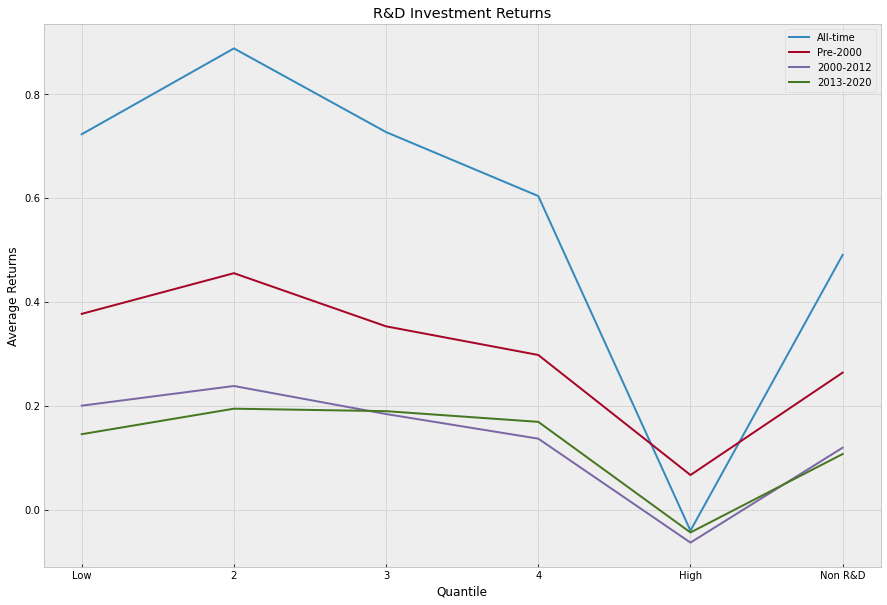

In [14]:
df = pd.DataFrame(columns= ["Low",2,3,4,"High","Non R&D"], index=["All-time", "Pre-2000","2000-2012","2013-2020"]).fillna(0.0)
# for year, col in yearly_rcd_class.iloc[:,:-8].iteritems():
for year, col in yearly_rcd_class.iteritems():
    brackets = get_brackets(col)
    for label in brackets.keys():
        t = set(crsp_monthly_avg_returns.index).intersection(set(brackets[label]))
        df.loc["All-time",label] += crsp_monthly_avg_returns[year][list(t)].dropna().mean()

    if year < 2000:
        for label in brackets.keys():
            t = set(crsp_monthly_avg_returns.index).intersection(set(brackets[label]))
            df.loc["Pre-2000",label] += crsp_monthly_avg_returns[year][list(t)].dropna().mean()
    
    if (year >= 2000) and (year < 2012):
        for label in brackets.keys():
            t = set(crsp_monthly_avg_returns.index).intersection(set(brackets[label]))
            df.loc["2000-2012",label] += crsp_monthly_avg_returns[year][list(t)].dropna().mean()
    
    if year >= 2012:
        for label in brackets.keys():
            t = set(crsp_monthly_avg_returns.index).intersection(set(brackets[label]))
            df.loc["2013-2020",label] += crsp_monthly_avg_returns[year][list(t)].dropna().mean()


df.T.plot(kind = "line",
        figsize = (15,10),
        xlabel = "Quantile",
        ylabel = "Average Returns",
        title = "R&D Investment Returns"
    )
df

In [15]:
# yearly_rcd_class.apply(lambda cols: print(cols.name))

In [16]:
# full_term_return = crsp_monthly_data.groupby(["PERMNO"])["RET"].agg("mean")
# full_term_return

In [17]:
# from functools import reduce

# def annualised_returns(rets: pd.Series)->float:
#     return (rets + 1).prod() - 1

In [18]:
# crsp_annualised_returns = crsp_monthly_data.groupby(["PERMNO", "year"])["RET"].agg(annualised_returns).unstack()
# crsp_annualised_returns

In [19]:
# # yearly_rcd_class.apply(lambda x: pd.get_dummies(x))
# def transform_cats(year_rcd: pd.Series)->pd.Series:
#     year = int(year_rcd.name)
#     # print("Year", year)
#     t = pd.get_dummies(year_rcd)
#     t.columns = pd.MultiIndex.from_tuples([(year, x) for x in t.columns])
#     return t

# t = pd.DataFrame([],#index=yearly_rcd_class.index,
#                 columns= pd.MultiIndex.from_tuples([(int(year), x) for x in ["Low",2,3,4,"High","Non R&D"] for year in yearly_rcd_class.columns]))
# t
# # t = transform_cats(yearly_rcd_class.iloc[:,1])
# # for year in yearly_rcd_class.columns[:2]:
#     # t = pd.concat([t, transform_cats(yearly_rcd_class[year])])
#     # t.iloc[int(year), :] = transform_cats(yearly_rcd_class[year])
# # t.ilo/c[1997, :]#t.columns.get_level_values(1) !='A']
# # # yearly_rcd_class.apply(lambda x: transform_cats(x))
# t

# WRDS

In [20]:
connection.list_libraries()

['aha',
 'aha_annual_survey_recent',
 'aha_hcris_recent',
 'aha_it_survey_recent',
 'aha_sample',
 'ahasamp',
 'audit',
 'audit_audit_comp',
 'audit_common',
 'audit_corp_legal',
 'auditsmp',
 'auditsmp_all',
 'bank',
 'blab',
 'block',
 'block_all',
 'boardex',
 'boardex_na',
 'boardex_trial',
 'boardsmp',
 'bvd',
 'bvd_ama_large',
 'bvd_ama_medium',
 'bvd_ama_small',
 'bvd_ama_verylarge',
 'bvdsamp',
 'calcbench_trial',
 'calcbnch',
 'cboe',
 'cboe_all',
 'centris',
 'ciq',
 'ciq_capstrct',
 'ciq_common',
 'ciq_keydev',
 'ciq_pplintel',
 'ciqsamp',
 'ciqsamp_common',
 'ciqsamp_transcripts',
 'cisdm',
 'cisdmsmp',
 'comp',
 'comp_bank',
 'comp_bank_daily',
 'comp_execucomp',
 'comp_global',
 'comp_global_daily',
 'comp_na_annual_all',
 'comp_na_daily_all',
 'comp_na_monthly_all',
 'comp_segments_hist',
 'comp_segments_hist_daily',
 'compa',
 'compb',
 'compbd',
 'compdcur',
 'compg',
 'compgd',
 'comph',
 'compm',
 'compmcur',
 'compnad',
 'compsamp',
 'compsamp_snapshot',
 'compseg',

In [21]:
library = "crspa"
connection.list_tables(library)

['acti',
 'asia',
 'asib',
 'asic',
 'asio',
 'asix',
 'bmdebt',
 'bmheader',
 'bmpaymts',
 'bmquotes',
 'bmyield',
 'bndprt06',
 'bndprt12',
 'bxcalind',
 'bxdlyind',
 'bxmthind',
 'bxquotes',
 'bxyield',
 'ccm_lookup',
 'ccm_qvards',
 'ccmxpf_linktable',
 'ccmxpf_lnkhist',
 'ccmxpf_lnkrng',
 'ccmxpf_lnkused',
 'comphead',
 'comphist',
 'compmaster',
 'crsp_daily_data',
 'crsp_header',
 'crsp_monthly_data',
 'crsp_names',
 'crsp_ziman_daily_index',
 'crsp_ziman_monthly_index',
 'cs20yr',
 'cs5yr',
 'cs90d',
 'cst_hist',
 'dport1',
 'dport2',
 'dport3',
 'dport4',
 'dport5',
 'dport6',
 'dport7',
 'dport8',
 'dport9',
 'dsbc',
 'dsbo',
 'dse',
 'dse62',
 'dse62delist',
 'dse62dist',
 'dse62exchdates',
 'dse62names',
 'dse62nasdin',
 'dse62shares',
 'dseall',
 'dseall62',
 'dsedelist',
 'dsedist',
 'dseexchdates',
 'dsenames',
 'dsenasdin',
 'dseshares',
 'dsf',
 'dsf62',
 'dsfhdr',
 'dsfhdr62',
 'dsi',
 'dsi62',
 'dsia',
 'dsib',
 'dsic',
 'dsio',
 'dsir',
 'dsix',
 'dsiy',
 'dsp500',


In [22]:
table = "ccmxpf_lnkused"
tbl = connection.get_table(library, table, obs=5)
print(tbl.columns)

InternalError: (psycopg2.errors.RaiseException)  'crspa.ccmxpf_lnkused' view is deprecated, please use 'crsp.ccmxpf_lnkused' or 'crsp_a_ccm.ccmxpf_lnkused' 
CONTEXT:  PL/pgSQL function crspa_err(text,text) line 3 at RAISE

[SQL: SELECT * FROM crspa.ccmxpf_lnkused  LIMIT 5 OFFSET 0;]
(Background on this error at: https://sqlalche.me/e/14/2j85)

In [ ]:
"liid" in tbl.columns